# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [1]:
# training on guanaco
# ATENTION: if it is going to run on guanaco, so comment the %matplotlib magic in next block
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 8
number_experiment = str(number_experiment)

# add general comment about experiment 
comment = "encoder as clasifier with periodic + variable (with class balancing)"

In [2]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# training
epochs = 5

# band
# passband = 5
passband = 5

batch_training_size = 128

In [3]:
# training params
learning_rate = 1e-3

# Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# Load data

In [5]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticc_torch-master/"

## Loading dataset with pytorch tool

In [6]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch1.csv


# Spliting data (train/test)

In [7]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())
#print(train_size)

# getting test splitting
validation_size = math.floor((torch_dataset_lazy.__len__() - train_size)/2)
#print(validation_size)

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, validation_size, test_size])

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

In [8]:
# count classes in dataloader
# return array of counter of each class
def countClasses(dataLoader):
    
    classCounter = np.zeros(shape = (len(only_these_labels),))
    
    for data in dataLoader:
        
        # count how many instance of class x
        for i in range(len(only_these_labels)):

            classCounter[i] += np.count_nonzero(data[1] == only_these_labels[i])
            
    return classCounter

initila distribution


<BarContainer object of 6 artists>

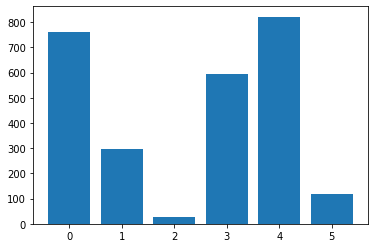

In [9]:
print("initila distribution")
initialClassesDistribution = countClasses(trainDataset)

fig, ax = plt.subplots()
ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

In [10]:
# This code was adapted from here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165212

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset 
        label_to_count = {}
        
        for idx in self.indices:
            label = self._get_label(dataset, idx)
#             label = 0]
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):  
        
        # edit this for work with this dataset
        return dataset[idx][1]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [11]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    trainDataset, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(trainDataset),
)

# validation loader
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size= batch_training_size,  num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

balanced distribution


<BarContainer object of 6 artists>

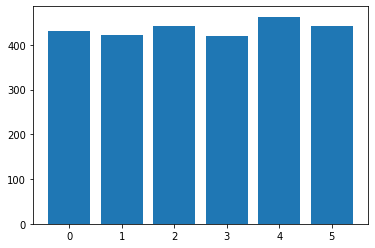

In [12]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader)

fig, ax = plt.subplots()
ax.bar(x = np.arange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

## Load the path to save model while training

In [13]:
import os

# create experiment's folder
folder_path = ("/home/lbravo/thesis/work/thesis/experiments/" + number_experiment) if trainingOnGuanaco else ("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.mkdir(folder_path)
    except OSError:
        print ("Creation of the directory %s failed" % folder_path)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = "/home/lbravo/thesis/thesis/work/thesis/experiments/" + number_experiment + "/model" if trainingOnGuanaco else "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/model"

folder already exists


In [14]:
# store varibales on file
text_file = open("experiments/" + number_experiment + "/experimentParameters.txt", "w")
text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
text_file.write(text)
text_file.close()
print("experiment parameters file created")

experiment parameters file created


## Define autoencoder structure

In [15]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [16]:
# building classifier

# encoder
class Encoder(torch.nn.Module):
    

    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim, num_classes):
    
    
        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv1 = torch.nn.Conv1d(1,64,3)
#         self.conv1 = torch.nn.Conv1d(1,64,3, stride = 2)
        
        # partial convolution
        self.pconv1 = PartialConv(in_channels_C = 1,in_channels_M = 1, out_channels = 64, kernel_size = 3, stride=2, padding=0, dilation=1, bias=True)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv2 = torch.nn.Conv1d(64, 32, 3)
#         self.conv2 = torch.nn.Conv1d(64, 32, 3, stride = 2)
        
        # partial convolution
        self.pconv2 = PartialConv(in_channels_C = 64,in_channels_M = 64, out_channels = 32, kernel_size = 3, stride=2, padding=0, dilation=1, bias=True)
        
        # linear layer
#         self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
#         self.hidden1 = torch.nn.Linear(1088, hidden_dim)
        self.hidden1 = torch.nn.Linear(1632, hidden_dim)
        
#         self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        # output layer
        self.outputLayer = torch.nn.Linear(hidden_dim, num_classes)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
#         self.activationConv = torch.nn.Tanh()
    
        # this works well.(comparing with relu)
        self.activationLinear = torch.nn.Tanh()

        # this is getting nan values
#         self.activationLinear = torch.nn.ReLU()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
#         print("input to encoder: ")
#         print(x.shape)
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]
        
        #conv to time
        # normal convolution
#         outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
#         outputTimeConv = self.activationConv(self.conv1(x[:, 0, :].unsqueeze(1)))
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputTimeConv, maskTime = self.pconv1(x[:, 0, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputTimeConv = self.activationConv(outputTimeConv)
        
        
        # conv to magnitude
#         outputMagConv = self.activationConv(self.conv1Mag(x[:, 1, :].unsqueeze(1)))
#         outputMagConv = self.activationConv(self.conv1(x[:, 1, :].unsqueeze(1)))
        
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputMagConv, maskMag = self.pconv1(x[:, 1, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputMagConv = self.activationConv(outputMagConv)
        
        
        # conv to mag error
#         outputMagErrorConv = self.activationConv(self.conv1(x[:, 2, :].unsqueeze(1)))
        
        # partial conv
        # output, newMask = pconv1(data, mask)
        outputMagErrorConv, maskError = self.pconv1(x[:, 2, :].unsqueeze(1), x[:, 3, :].unsqueeze(1))
        # activation function
        outputMagErrorConv = self.activationConv(outputMagErrorConv)
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        
        # conv to time
#         outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
        
        # partial conv
        outputTimeConv, maskTime = self.pconv2(outputTimeConv, maskTime)
        outputTimeConv = self.activationConv(outputTimeConv)
        
        
        # conv to flux
#         outputMagConv = self.activationConv(self.conv2(outputMagConv))
        # part conv
        outputMagConv, maskMag = self.pconv2(outputMagConv, maskMag)
        outputMagConv = self.activationConv(outputMagConv)
        
        # conv to mag error
#         outputMagErrorConv = self.activationConv(self.conv2(outputMagErrorConv))
        # partial conv
        outputMagErrorConv, maskError = self.pconv2(outputMagErrorConv, maskError)
        outputMagErrorConv = self.activationConv(outputMagErrorConv)
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
        outputMagErrorConv = outputMagErrorConv.view(outputMagErrorConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 3 towers
#         output = torch.cat((outputMagConv, outputTimeConv), 1)
        output = torch.cat((outputTimeConv, outputMagConv, outputMagErrorConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
#         print("before linear layer: {0}".format(output.shape))
        output = self.activationLinear(self.hidden1(output))
        # Should be an activiation function here?
#         output = (self.hidden1(output))
        
        output = self.outputLayer(output)
        
        # this should return the classification
        return output

## Defining parameters to Autoencoder

In [17]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

passband = passband

num_classes = len(only_these_labels)


# defining model
model = Encoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes)

# mdel to GPU
model = model.cuda()

In [18]:
print(model)

Encoder(
  (pconv1): PartialConv(
    (input_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=1632, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


In [19]:
# # print("input dimension: {0}".format(len(list(trainLoader))))

# # parameters number
# count = 0

# # # check model dimension
# for name, param in model.state_dict().items():
#     # name: str
#     # param: Tensor
# #     print("{0}: {1} \n".format(name, param.shape))
# #     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
# #     print(param.shape)
#     count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# # for param in model.parameters():
    
# print("number of parameters: " + str(count))

In [20]:
# it builds a mask for the deltas. It compares the next with the previous one element.
# original mask: [1,1, 0, 0]
# delta mask: [1, 0, 0]
# The same results is got with original_mask[:, 1:]
def generate_delta_mask(mask):
    
    # generate delta mask
#     mask_delta = mask[:, 1:].type(torch.BoolTensor) & mask[:, :-1].type(torch.BoolTensor)
    mask_delta = mask[:, 1:]
    
    return mask_delta

In [21]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # delta errors
    tmpDeltaMagError = data[:, passBand, 2, 1:] - data[:, passBand, 2, :-1]
    
    # delta mask
    tmpMask = generate_delta_mask(data[:, passBand, 3,:])
    
    # concatenate tensors
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1), tmpDeltaMagError.unsqueeze(1), tmpMask.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    # this was commented because it considerate that delta is already a normalization
#     dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

In [22]:
# mapping the labels to classes 0 to C-1

def mapLabels(labels):

    for i in range(len(only_these_labels)):
        
        labels[labels == only_these_labels[i]] = i 
        
    return labels

In [23]:
# # test mapLabels function

# # input
# input_ = np.array([16, 92, 53, 16, 53])
# labels = np.array([0, 1, 2, 0, 2])

# # output
# output = mapLabels(input_)

# # # test
# assert np.array_equal(output,  labels) == True, "Should be 0, 1, 2"

# print("test ok")

In [24]:
# save best model
def saveBestModel(model, pathToSaveModel, number_experiment, nepoch, newError):
    
    print("New min test loss. Saving model")

#         print("old: ", currentError)
#         print("new: ", newError)

    # save model
    torch.save(model.state_dict(), pathToSaveModel)

    # write metrics
    text_file = open("experiments/" + number_experiment + "/bestScoresModelTraining.txt", "w")
    metricsText = "Epoch: {0}\n Reconstruction test error: {1}".format(nepoch, newError)
    text_file.write(metricsText)
    text_file.close()
        

### Training

starting the training
epoch:    0 / 5
early stopping counter:  2
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    1 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    2 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    3 / 5
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    4 / 5
New min test loss. Saving model
saving losses
saving f1 scores
training has finished


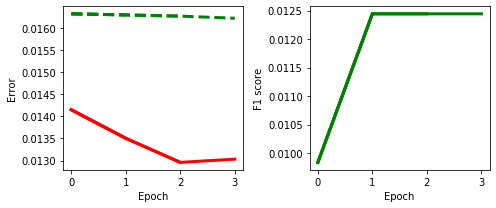

In [25]:
from sklearn.metrics import f1_score

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    # # fig, ax = plt.subplots()
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 20


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    epoch_train_loss = 0
    
    for data_ in trainLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
        
        optimizer.zero_grad()
            
        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

        # get model output
        outputs = model.forward(data)
        
        # loss function
        loss = lossFunction(outputs, mapLabels(labels).cuda())
        
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        

    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    
    
    ##### Validation ########
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # minibatches
    for data_ in validationLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
        
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
        
        outputs = model.forward(data)
        
        # loss function
        loss = lossFunction(outputs, mapLabels(labels).cuda())
    
        #  store minibatch loss value
        epoch_test_loss += loss.item()
        
        # f1 score
        f1Score += f1_score(mapLabels(labels).cpu().numpy(), torch.argmax(outputs, 1).cpu().numpy(), average = "micro")
        
        # batch counter
        batchCounter += 1
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    
    
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    #### Early stopping #####
    
    
    
    # if new test loss is greater than the older one
    count_early_stop += 1
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("experiments/" + number_experiment + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n, Reconstruction test error: {2}".format(nepoch, count_early_stop, epoch_test_loss)
        text_file.write(metricsText)
        text_file.close()
        break
        
        
        
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar)
                
   


    # save losses
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("experiments/" + number_experiment + "/training_losses.csv", losses, delimiter=",")
    

    
    
    # save f1 scores
    print("saving f1 scores")
    np.savetxt("experiments/" + number_experiment + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
# final message
print("training has finished")

In [26]:
# get confusion matrix and classification report
def getConfusionAndClassificationReport(dataSet, nameLabel):
    
    # get y true and labels
    predictions = np.zeros(shape = (0,))
    labels_ = np.zeros(shape = (0,))

    # minibatches
    for data_ in dataSet:

        data = data_[0].cuda()
        labels = data_[1].cuda()

        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

        outputs = model.forward(data)

        prediction = torch.argmax(outputs, 1).cpu().numpy()

        label = mapLabels(labels).cpu().numpy()

        predictions = np.append(predictions, prediction)
        labels_ = np.append(labels_, label)


    # getting confusion amtrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels_, predictions)

    print("saving confusion matrix scores")
    np.savetxt("experiments/" + number_experiment + "/confusionMatrix" + nameLabel + ".csv", cm, delimiter=",")


    # classification report
    print("saving clasification report")
    text_file = open("experiments/" + number_experiment + "/clasificationReport" + nameLabel + ".txt", "w")
    text = classification_report(labels_, predictions)
    text_file.write(text)
    text_file.close()

In [27]:
# get metrics on trainig dataset
getConfusionAndClassificationReport(trainLoader, nameLabel = "Train")


# get metrics on validation dataset
getConfusionAndClassificationReport(validationLoader, nameLabel = "Validation")

saving confusion matrix scores
saving clasification report


/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


saving confusion matrix scores
saving clasification report


### Stop execution if it's on cluster

In [28]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

# Analyzing training

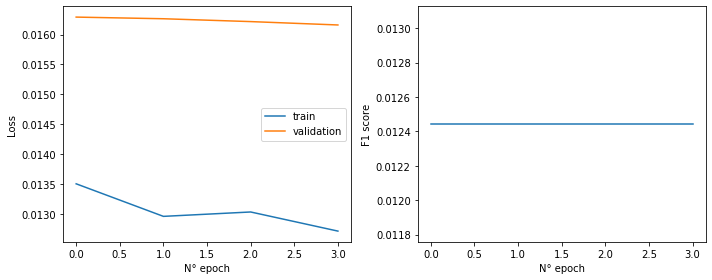

In [29]:
# load losses array
losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/training_losses.csv")

# f1 scores
f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:, 0], label = "train")
ax[0].plot(losses.iloc[:, 1], label = "validation")
# ax[0].scatter(429, 0.000845159766508081, c = "r", linewidths = 10)
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores)
# ax[1].scatter(429, f1Scores.iloc[428], c = "r", linewidths = 10)


# ax[0].scatter(429, 0)

In [30]:
!cat experiments/7/bestScoresModelTraining.txt

cat: experiments/7/bestScoresModelTraining.txt: No existe el archivo o el directorio


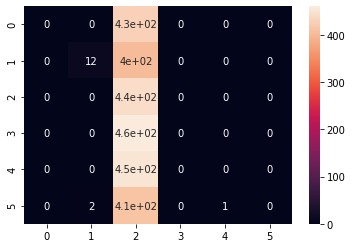

In [42]:
# confusion matrix
import pandas as pd
import seaborn as sn

# get confusion matrix
cm = pd.read_csv('./experiments/' + number_experiment + '/confusionMatrixTrain.csv', header = None) 
# cm = pd.read_csv('./experiments/' + number_experiment + '/confusionMatrixValidation.csv', header = None) 

sn.heatmap(cm, annot=True)

In [44]:
# classification report
!cat ./experiments/8/clasificationReportTrain.txt

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       430
         1.0       0.86      0.03      0.06       416
         2.0       0.17      1.00      0.29       443
         3.0       0.00      0.00      0.00       461
         4.0       0.00      0.00      0.00       453
         5.0       0.00      0.00      0.00       417

    accuracy                           0.17      2620
   macro avg       0.17      0.17      0.06      2620
weighted avg       0.16      0.17      0.06      2620


In [45]:
# classification report
!cat ./experiments/8/clasificationReportValidation.txt

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        80
         1.0       0.00      0.00      0.00        39
         2.0       0.01      1.00      0.02         4
         3.0       0.00      0.00      0.00        76
         4.0       0.00      0.00      0.00       104
         5.0       0.00      0.00      0.00        25

    accuracy                           0.01       328
   macro avg       0.00      0.17      0.00       328
weighted avg       0.00      0.01      0.00       328
